# 3.モンテカルロ法

In [33]:
import gym
import numpy as np
import pandas as pd

env = gym.make('FrozenLake-v0', is_slippery=False)
env.render()


SFFF
FHFH
FFFH
HFFG


* 「ゲームをやってみた結果、もらった報酬」を元に価値計算
* 今回の「価値」は、Q(s, a)で表される、「行動の価値」

In [2]:
class MonteCarlo:
    def __init__(self, env):
        self.env = env
        self.Q = {}
        self.initialize()
    
    # Q値（各状態における各行動の価値）を初期化
    def initialize(self):
        for s in range(self.env.nS):
            self.Q[s] = [0] * self.env.nA
        self.env.reset()

In [3]:
mc = MonteCarlo(env)
mc.Q

{0: [0, 0, 0, 0],
 1: [0, 0, 0, 0],
 2: [0, 0, 0, 0],
 3: [0, 0, 0, 0],
 4: [0, 0, 0, 0],
 5: [0, 0, 0, 0],
 6: [0, 0, 0, 0],
 7: [0, 0, 0, 0],
 8: [0, 0, 0, 0],
 9: [0, 0, 0, 0],
 10: [0, 0, 0, 0],
 11: [0, 0, 0, 0],
 12: [0, 0, 0, 0],
 13: [0, 0, 0, 0],
 14: [0, 0, 0, 0],
 15: [0, 0, 0, 0]}

## 3.1モンテカルロ法の理論
Q(s,a)は、「状態sでaという行動をしたときに、ゲーム終了までに得られる報酬」で決める。

$$G_t = r_{t+1} + r_{t+2} + \cdots + r_T$$

今回はゲーム終了時にしか報酬をもらえないため、結局は$G_t = r_T$となる

ただ、未来でもらえる報酬は不確かな値なので、「割引」$\gamma$をかける。
$$G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \cdots + \gamma^{T-t-1} r_T$$
これを、「割引現在価値」という。
$$Q(s,a) \leftarrow Q(s,a) + \alpha (G_t - Q(s,a))$$

$\alpha$は、「学習率」で0から1を取る。Qの更新は1ゲーム終了したら行われる。

In [42]:
class MonteCarlo:
    def __init__(self, env):
        self.env = env
        self.Q = {}
        self.initialize()
        self.reward_log = []
    
    # Q値（各状態における各行動の価値）を初期化
    def initialize(self):
        for s in range(self.env.nS):
            self.Q[s] = [0] * self.env.nA
        self.env.reset()
    
    def policy(self, s, epsilon=0.1):
        if np.random.random() < 0.1:
            return np.random.randint(self.env.nA)
        else:
            if sum(self.Q[s]) == 0:
                return np.random.randint(self.env.nA)
            else:
                return np.argmax(self.Q[s])
    
    # モンテカルロ法実行フェーズ
    def learn(self, episode_count=1000, gamma=0.9, alpha=0.8):
        # エピソードの反復
        for e in range(episode_count):
            done = False
            experience_log = []
            s = 0
            self.env.reset()
            
            # エピソードを実行→エピソードの終了まで実行
            while not done:
                # とりあえずランダムに行動を選択
                a = self.policy(s)
                # 行動を実行して、次の状態:next_s、報酬:reward、終了したかどうか:doneを取得する
                next_s, reward, done, _ = self.env.step(a)
                #　「現在の状態」から「ある行動」をとったときの「価値」と「次の状態」をログとして保存する
                experience_log.append({'state':s, 'action':a, 'reward':reward, 'next_state':next_s})
                s = next_s
            else:
                self.reward_log.append(reward)
            
            # エピソードで取得したログからQ値を更新
            for t, experience in enumerate(experience_log):
                G = 0
                i = 0
                # エピソードでt回目にいた状態、行動の組み合わせにおける割引現在価値を計算
                s = experience['state']
                a = experience['action']
                for j in range(t, len(experience_log)):
                    G += (gamma**i) * experience_log[j]['reward']
                    i += 1
                # Q値の更新
                self.Q[s][a] += alpha * (G - self.Q[s][a])
        #return self.Q
        #return self.reward_log
    
    def show_reward(self, interval=50):
        average_reward = []
        for e in range(0, len(self.reward_log), interval):
            average_reward.append(np.mean(self.reward_log[e:e+interval]))
        return pd.Series(average_reward)

確率10％:探索、確率90％:活用  
探索：ランダムに行動する  
活用:Q(s,a)から最善の行動をとる

In [43]:
mc = MonteCarlo(env)
mc.learn()

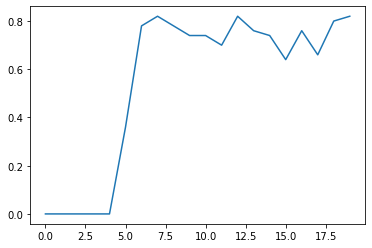

In [46]:
import matplotlib.pyplot as plt
plt.plot(mc.show_reward())